# Deep Learning Modell - Swiss Image - Kreisel erkennen

> Beat Brändli

## Imports

In [1]:
#import sys; sys.path.append(model_beat.ipynb)  # working dir


In [2]:
# deep learning libraries
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))
from tensorflow import keras
#import keras_cv  # for special layers (data augmentation)

# machine learning libraries
#import sklearn
#from sklearn.model_selection import train_test_split
#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import StandardScaler
#print(sklearn.show_versions())

# data handling
import math
import numpy as np

# visualisierung
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
plt.rcParams['figure.dpi'] = 150
import sys
from PIL import Image
sys.modules['Image'] = Image 

TensorFlow version: 2.12.0
[]


## Datensatz laden

In [3]:
from dataset_beat import get_train, get_val, get_test

In [4]:
HEIGHT = 1250
WIDTH = 1250

In [5]:
train_generator = get_train()
train_images = train_generator

Found 400 images belonging to 2 classes.


In [6]:
validation_generator = get_val()
val_images = validation_generator

Found 100 images belonging to 2 classes.


In [7]:
test_generator = get_test()
test_images = test_generator

Found 100 images belonging to 2 classes.


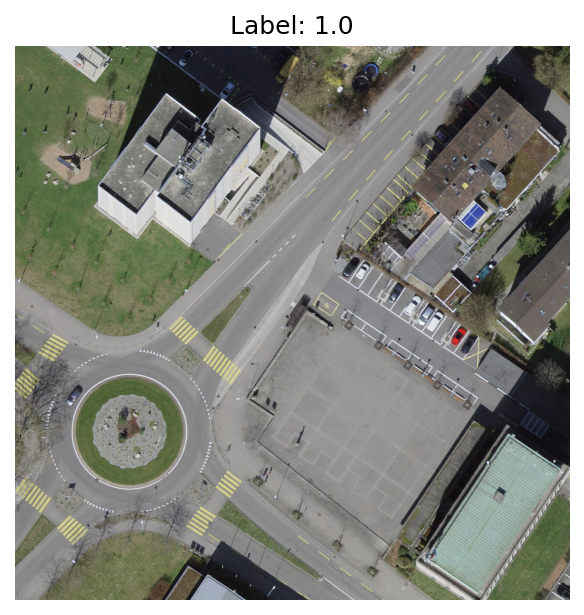

1250


In [8]:
def print_example_image(images):
    batch_images, batch_labels = next(images)  # Get a batch of images and labels

    example_image = batch_images[0]  # Select the first image from the batch
    example_label = batch_labels[0]  # Corresponding label for the first image

    # Display the image and label
    plt.imshow(example_image)
    plt.title('Label: {}'.format(example_label))
    plt.axis('off')
    plt.show()
    print(len(example_image))

print_example_image(test_images)


In [9]:
def plot_scores(model, train_images, test_images, val_images, savefigname=None):
    print("test score:")
    test_results = model.evaluate(test_images)
    test_results = dict(zip(model.metrics_names, test_results))

    print("train score:")
    train_results = model.evaluate(train_images)
    train_results = dict(zip(model.metrics_names, train_results))

    print("val score:")
    val_results = model.evaluate(val_images)
    val_results = dict(zip(model.metrics_names, val_results))

    accuracy = [test_results["accuracy"], train_results["accuracy"], val_results["accuracy"]]
    loss = [test_results["loss"], train_results["loss"], val_results["loss"]]

    X = ["test", "train", "val"]
    X_axis = np.arange(len(X))

    plt.bar(X_axis - 0.2, accuracy, 0.4, label = 'accuracy')
    plt.bar(X_axis + 0.2, loss, 0.4, label = 'loss')

    for i, (x, accuracy, loss) in enumerate(zip(X_axis, accuracy, loss)):
        plt.text(x - 0.25, accuracy + 0.01, str(round(accuracy, 3)), color='blue', fontsize=10)
        plt.text(x + 0.1, loss + 0.01, str(round(loss, 3)), color='orange', fontsize=10)

    plt.xticks(X_axis, X)
    plt.xlabel("Data")
    plt.ylabel("accuracy/loss")
    plt.title("Accuracy/Loss per Data")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    if savefigname:
        plt.savefig(savefigname, bbox_inches='tight')
    plt.show()

In [10]:
def plot_acc_curve(trainHistory, savefigname=None):
    plt.figure(figsize=(8,6))
    plt.plot(trainHistory.history['accuracy'])
    plt.plot(trainHistory.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.grid()
    plt.title("Model Accuracy")
    if savefigname:
        plt.savefig(savefigname, bbox_inches='tight')
    plt.show()

In [11]:
def plot_loss_curve(trainHistory, savefigname=None):
    plt.figure(figsize=(8,6))
    plt.plot(trainHistory.history['loss'])
    plt.plot(trainHistory.history['val_loss'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.grid()
    plt.title("Model Loss")
    if savefigname:
        plt.savefig(savefigname, bbox_inches='tight')
    plt.show()

## Pretrained Model

### Base Model

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(2),
  tf.keras.layers.RandomContrast(0.5),
  tf.keras.layers.RandomTranslation(0.3,0.3)


])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=20,
                                      restore_best_weights=True,
                                      verbose=1)

In [13]:
model_name = "RESNET 50"
LR = 0.0001
initial_epoch = 30


base_model_resnet = tf.keras.applications.VGG16(input_shape=(HEIGHT,WIDTH, 3),
                                            include_top=False,
                                            weights='imagenet')

base_model_resnet.trainable = False

"""image_batch, label_batch = next(iter(train_images))
feature_batch = base_model_resnet(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)"""

inputs = tf.keras.Input(shape=(HEIGHT,WIDTH, 3))
inputs = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model_resnet(x, training=False)  # important: training=False
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

base_model_resnet_final = tf.keras.Model(inputs, outputs)

base_model_resnet_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

print(base_model_resnet_final.summary())

trainHistory = base_model_resnet_final.fit(
  train_images,
  validation_data=val_images,
  callbacks=[es], 
  epochs=initial_epoch,
  verbose=1
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1250, 1250, 3)]   0         
                                                                 
 tf.__operators__.getitem (S  (None, 1250, 1250, 3)    0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 1250, 1250, 3)    0         
                                                                 
 vgg16 (Functional)          (None, 39, 39, 512)       14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

In [14]:
base_model_resnet_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1250, 1250, 3)]   0         
                                                                 
 tf.__operators__.getitem (S  (None, 1250, 1250, 3)    0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 1250, 1250, 3)    0         
                                                                 
 vgg16 (Functional)          (None, 39, 39, 512)       14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

test score:
10/10 [==============================] - 198s 20s/step - loss: 0.6914 - accuracy: 0.5000
train score:
40/40 [==============================] - 669s 17s/step - loss: 0.6917 - accuracy: 0.5000
val score:
10/10 [==============================] - 164s 16s/step - loss: 0.6909 - accuracy: 0.5000


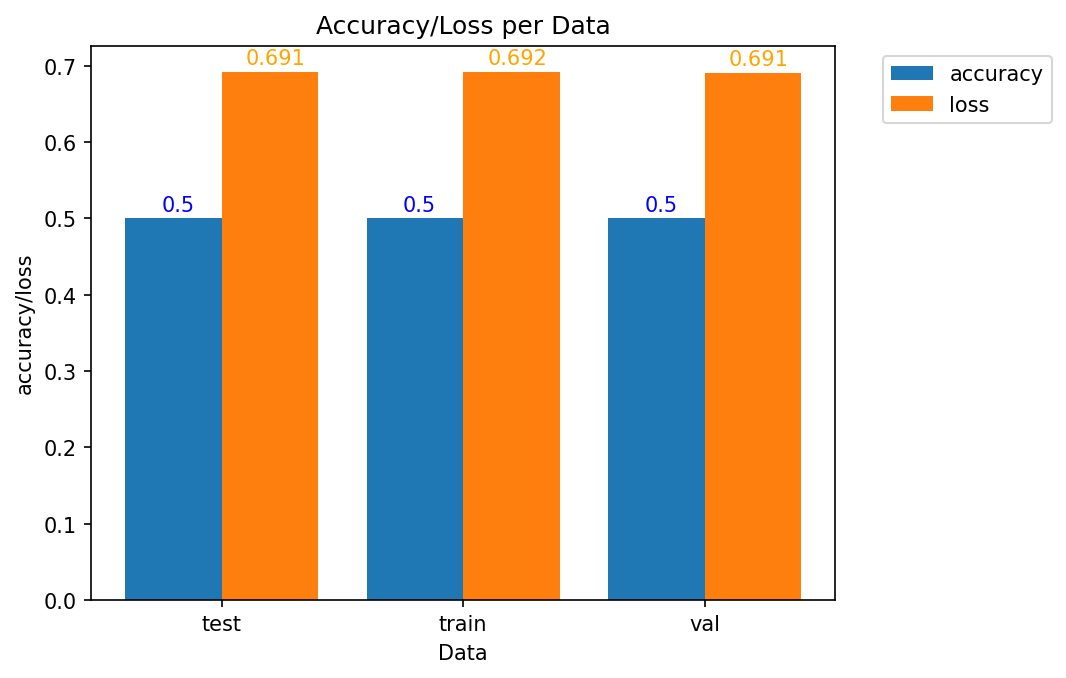

In [15]:
plot_scores(base_model_resnet_final, train_images, test_images, val_images, savefigname=None)

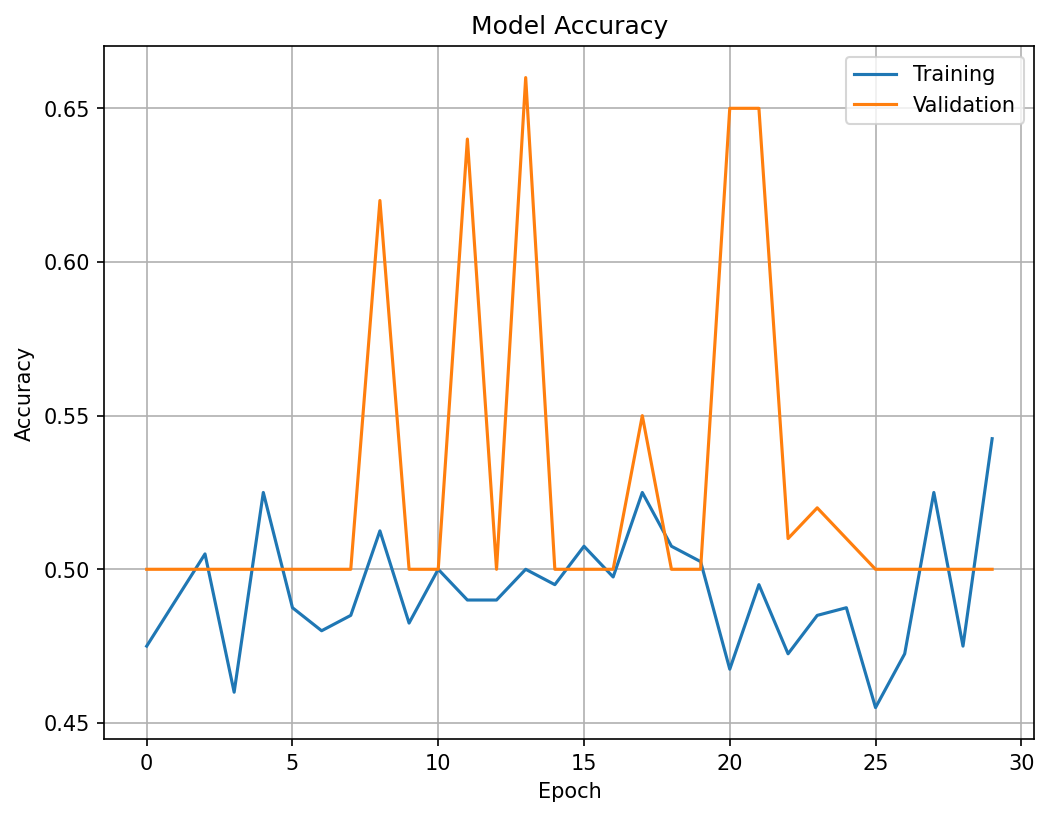

In [16]:
plot_acc_curve(trainHistory)

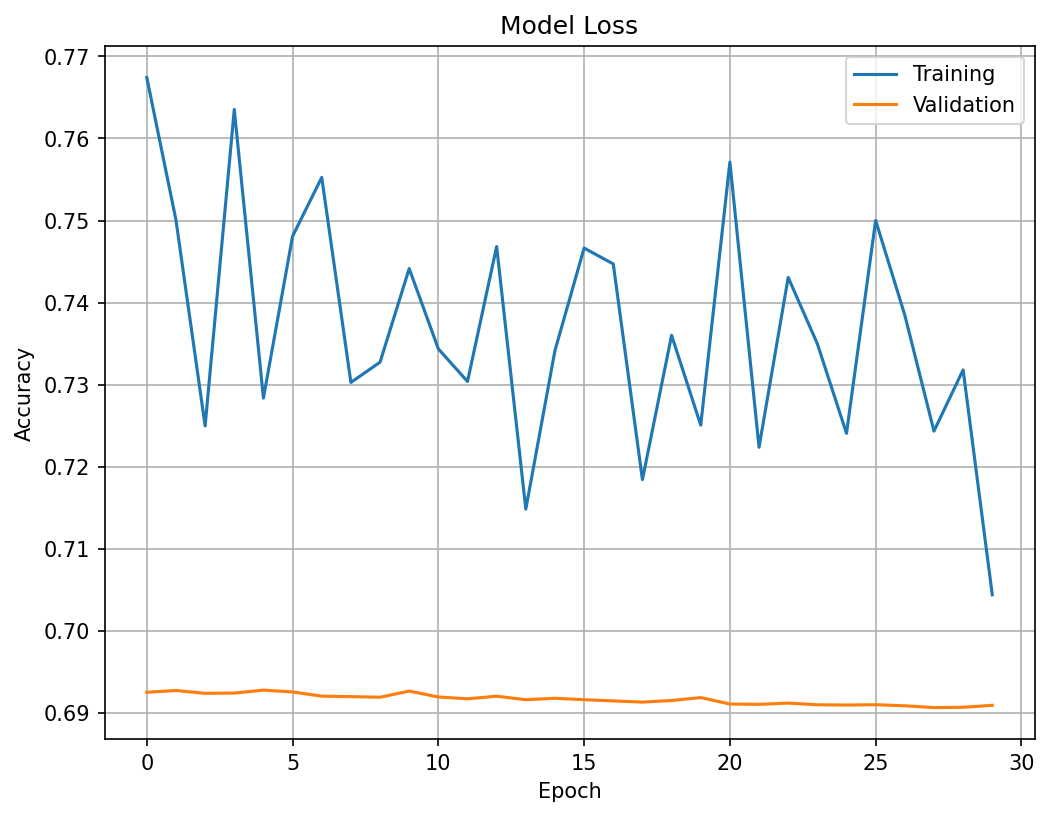

In [17]:
plot_loss_curve(trainHistory)

In [18]:
base_model_resnet.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model_resnet.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_resnet.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  19


In [19]:
optimized_model = tf.keras.Sequential([
    # Data augmentation
    tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(HEIGHT, WIDTH, 3)),
    tf.keras.layers.RandomRotation(0.2),  # fraction of 2 pi
    #tf.keras.layers.RandomZoom(0.3),
    #tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomContrast(0.2),
    # Rest of Model
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2), (2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2), (2, 2)),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimized_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
trainHistory = optimized_model.fit(
  train_images,
  validation_data=val_images,
  callbacks=[es], 
  epochs=initial_epoch,
  verbose=1
)

Epoch 1/30
40/40 [==============================] - 699s 17s/step - loss: 0.6953 - accuracy: 0.4600 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/30
40/40 [==============================] - 700s 17s/step - loss: 0.6943 - accuracy: 0.5150 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 3/30
40/40 [==============================] - 706s 18s/step - loss: 0.6940 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/30
40/40 [==============================] - 820s 21s/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/30
40/40 [==============================] - 854s 21s/step - loss: 0.6942 - accuracy: 0.4775 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/30
40/40 [==============================] - 739s 18s/step - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 7/30
40/40 [==============================] - 702s 18s/step - loss: 0.6900 - accuracy: 0.5225 - val_loss: 0.6870 - val_accuracy: 0.6100
Epoch 

In [22]:
optimized_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 1250, 1250, 3)     0         
                                                                 
 random_rotation_1 (RandomRo  (None, 1250, 1250, 3)    0         
 tation)                                                         
                                                                 
 random_contrast_1 (RandomCo  (None, 1250, 1250, 3)    0         
 ntrast)                                                         
                                                                 
 conv2d (Conv2D)             (None, 1248, 1248, 32)    896       
                                                                 
 conv2d_1 (Conv2D)           (None, 1246, 1246, 32)    9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 623, 623, 32)    

In [23]:
plot_scores(base_model_resnet_final, train_images, test_images, val_images, savefigname=None)

test score:
10/10 [==============================] - 166s 17s/step - loss: 0.6914 - accuracy: 0.5000
train score:
 1/40 [..............................] - ETA: 12:14 - loss: 0.6932 - accuracy: 0.5000

In [ ]:
plot_acc_curve(trainHistory)

In [ ]:
plot_loss_curve(trainHistory)

In [21]:
base_model.save('base_model.h5')

NameError: name 'base_model' is not defined

# Problemstellung
Wir wollen mit unserem CNN Kreisel aus der Vogelperspektive erkennen.
Das könnte für den Bund interessant sein, um die Verkehrsplanung zu verbessern. Mit Hilfe der Verkehrs-/Staudaten und der Information, ob sich ein Kreisel in der Nähe diese Staus befinedet, könnte man Rückschlüsse über die Effektivität von diesem Kreisel ziehen.

ENDE